In [1]:
%matplotlib inline

import sys
import os
sys.path.append('C:/Users/samrari/ComputBuffer')

import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from PIL import Image

from osgeo import gdal
import osr
from my_packages.My_Geoprocess import*

from sklearn.cluster import KMeans


In [2]:
mode = 'all' 

In [3]:
rasters_data_path = "C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/GRANULE/L1C_T58KFA_A010823_20170718T231219/IMG_DATA/Deglinted/"
raster_data_path = [f for f in os.listdir(rasters_data_path) if f.endswith('.tif')]
bands_data = []

for f in range(len(raster_data_path)):
    raster_dataset = gdal.Open(rasters_data_path+raster_data_path[f], gdal.GA_ReadOnly)
    for b in range(1, raster_dataset.RasterCount+1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        
        
for i in range(len(bands_data)):
    print(bands_data[i].shape)
bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape
print(bands_data.shape)

idx = np.array([3,2,1,0,4])
bands_data = bands_data[:,:,idx]

raster_dataset = gdal.Open(rasters_data_path+raster_data_path[0], gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
del raster_dataset

(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980, 5)


In [4]:
MaskFilePath = 'C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/Mask/'
DeepIndex = create_mask_from_vector(MaskFilePath + 'Deep.shp', cols, rows, geo_transform, proj, target_value=1, format=gdal.GDT_Byte)
DeepIndex = DeepIndex.GetRasterBand(1).ReadAsArray().astype(bool)


B02_06.shp
B02_07.shp
B02_08.shp
B02_09.shp
B02_10.shp
B02_11.shp
B02_12.shp
B02_13.shp
B02_14.shp
B02_15.shp


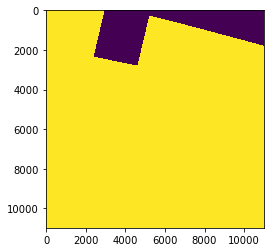

In [5]:
FootprintFilePath = 'C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/Mask/FootPrint/'
MaskFilePath = 'C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/Mask/'
raster_dataset = gdal.Open(rasters_data_path+raster_data_path[0], gdal.GA_ReadOnly)
cols = raster_dataset.RasterXSize
rows = raster_dataset.RasterYSize
FootPrint = []
GlobalFootPrint = np.full((rows,cols), False, dtype=bool)

for File in GetSimpleFiles("B02*.shp", directory=FootprintFilePath):
    print(File)
    FootPrint.append(create_mask_from_vector(FootprintFilePath + File, cols, rows, geo_transform, \
                                             proj, target_value=1, format=gdal.GDT_Byte))

if len(FootPrint)>1:
    for i in range(len(FootPrint)):
        FootPrint[i] = FootPrint[i].GetRasterBand(1).ReadAsArray().astype(bool)
        GlobalFootPrint += FootPrint[i]

    FootPrintBoarders = np.full(FootPrint[0].shape[0:2] , False, dtype= bool)

    for i in range(1,len(FootPrint)):
        FootPrintBoarders[np.logical_and(FootPrint[i-1], FootPrint[i])] = True
    FootPrintBoarders[np.logical_and(FootPrint[i], FootPrint[2])] = True
else:
    FootPrint[0] = FootPrint[0].GetRasterBand(1).ReadAsArray().astype(bool)
    GlobalFootPrint = FootPrint[0]
plt.imshow(GlobalFootPrint)


percentiles  5 ,  95  of band  0 :  370.0 ,  1358.0 

percentiles  5 ,  95  of band  1 :  749.0 ,  1210.0 

percentiles  5 ,  95  of band  2 :  432.0 ,  1034.0 

percentiles  5 ,  95  of band  3 :  215.0 ,  924.0 

percentiles  5 ,  95  of band  4 :  171.0 ,  1198.0 



(-0.5, 10979.5, 10979.5, -0.5)

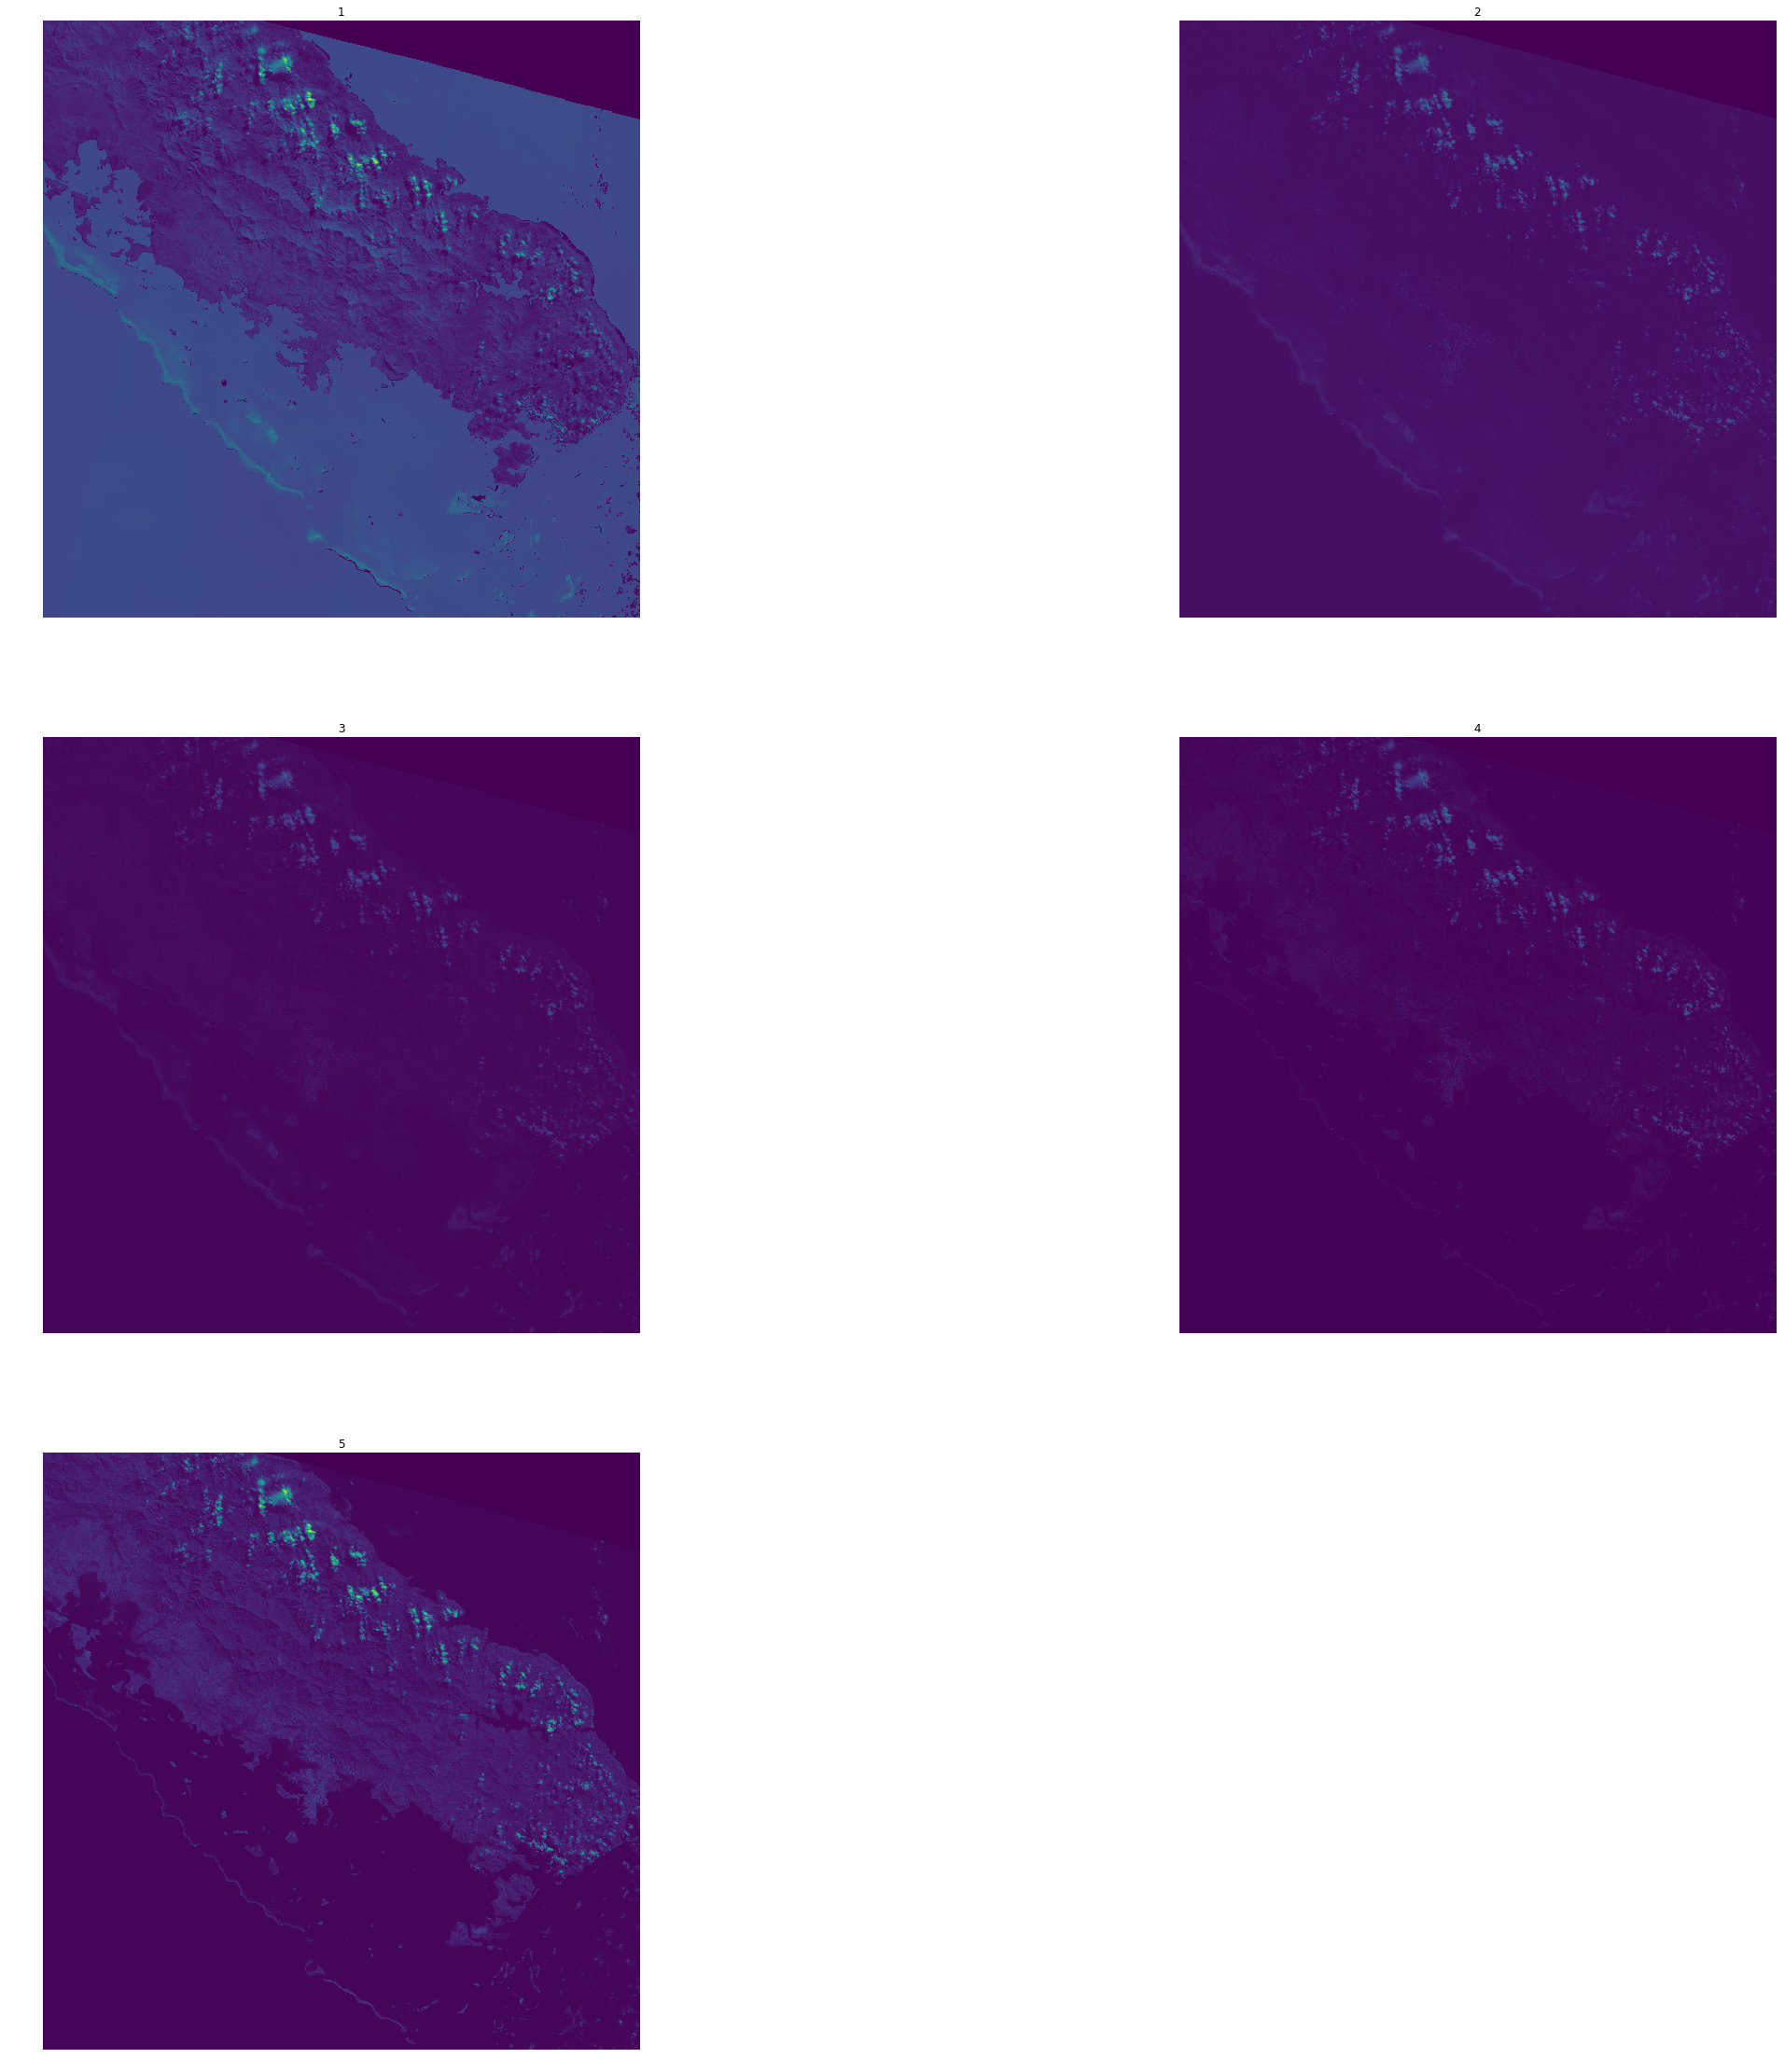

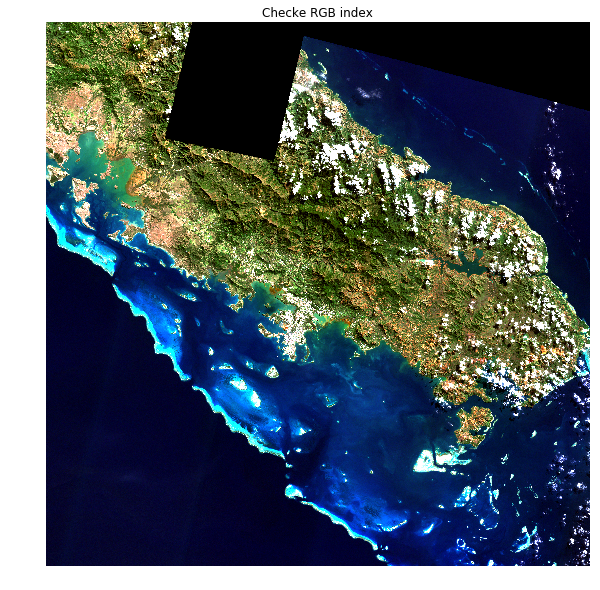

In [6]:
plt.figure(figsize=(40, 40))

for i in range(1,6):
    plt.subplot(3, 2, i)
    plt.imshow(img_as_float(bands_data[:,:,i-1]))
    plt.title(str(i))
    plt.axis('off')
    
better_contrast = np.empty((10980, 10980, 5), dtype= bands_data.dtype)

p_min = 5
p_max = 95
for i in range(bands_data.shape[2]):
    v_min, v_max = np.percentile(bands_data[:,:,i][GlobalFootPrint], (p_min, p_max))
    print('percentiles ',p_min,', ',p_max,' of band ',str(i),': ',str(v_min),', ',str(v_max),'\n')
    better_contrast[:,:,i][GlobalFootPrint] = exposure.rescale_intensity(bands_data[:,:,i][GlobalFootPrint], in_range=(v_min, v_max))
     
    
plt.figure(figsize=(10, 10))
RGBIdx = np.array([3,2,1])
plt.imshow(img_as_float(better_contrast[:,:,RGBIdx]))
plt.title('Checke RGB index')
plt.axis('off')


In [6]:
shapefile_path = ["D:/Image/processed/S2A_OPER_PRD_MSIL1C_PDMC_20161101T012450_R101_V20161031T230902_20161031T230902.SAFE/Mask/ROI_RangeDepth_SameBoTy.shp"]
FilePath = 'C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_OPER_PRD_MSIL1C_PDMC_20161101T012450_R101_V20161031T230902_20161031T230902.SAFE/'

labeled_pixels = vectors_to_raster(shapefile_path, rows, cols, geo_transform, proj)

for i in np.unique(labeled_pixels):
    print('Occurence of label {0: d} : {1: d}'.format(i, np.sum(labeled_pixels == i)))


Occurence of label  0 :  120307197
Occurence of label  1 :  253203


Occurence of label  0 :  120307197
Occurence of label  1 :  16605
Occurence of label  2 :  2446
Occurence of label  3 :  39569
Occurence of label  4 :  75003
Occurence of label  5 :  6003
Occurence of label  6 :  113577


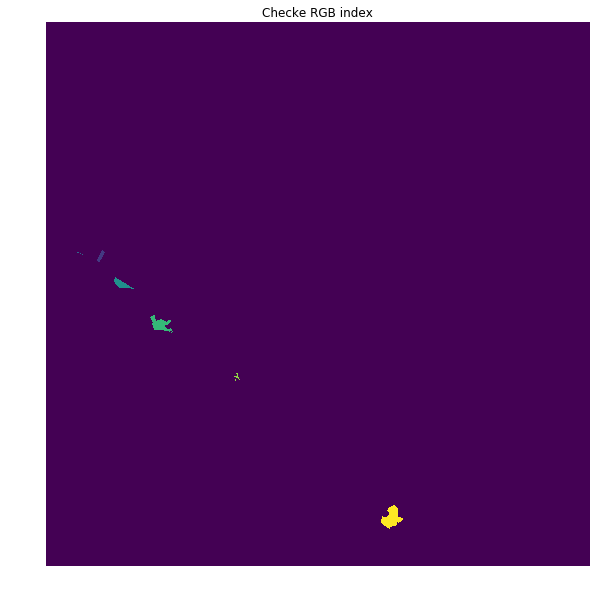

In [7]:
plt.figure(figsize=(10, 10))
labeled_pixels = label(labeled_pixels)
plt.imshow(labeled_pixels)
plt.title('Checke RGB index')
plt.axis('off')

for i in np.unique(labeled_pixels):
    print('Occurence of label {0: d} : {1: d}'.format(i, np.sum(labeled_pixels == i)))


In [8]:
npzfile = np.load('X_Package__all.npz')
X = npzfile['arr_0']
ErMap = npzfile['arr_1']

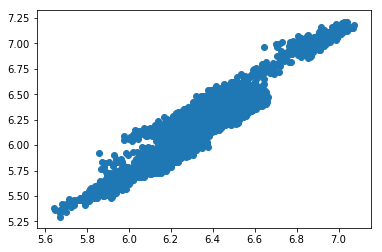

In [14]:
i = 5
plt.scatter(X[labeled_pixels==i,1],X[labeled_pixels==i,2])



In [9]:
from scipy import stats
stats.linregress(X[labeled_pixels==5,1],X[labeled_pixels==5,2])

LinregressResult(slope=1.3240983896340099, intercept=-2.2240904805429551, rvalue=0.94182741060077591, pvalue=0.0, stderr=0.0060996038465381975)

In [ ]:
Cslope, Sslope

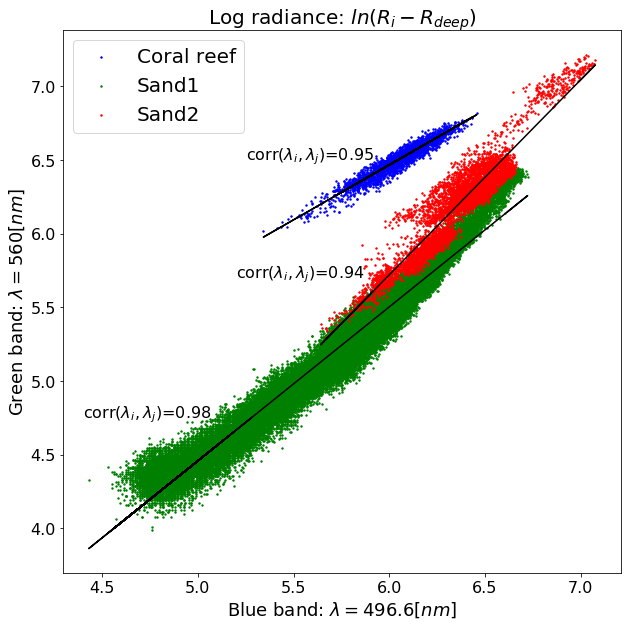

In [10]:
from scipy import stats

Cslope, Cintercept, Cr_value, Cp_value, Cstd_err = stats.linregress(X[labeled_pixels==2,1],X[labeled_pixels==2,2])
Sslope, Sintercept, Sr_value, Spvalue, Sstd_err = stats.linregress(X[labeled_pixels==6,1],X[labeled_pixels==6,2])
Ssslope, Ssintercept, Ssr_value, Sspvalue, Ssstd_err = stats.linregress(X[labeled_pixels==5,1],X[labeled_pixels==5,2])


plt.figure(figsize=((10,10)))
plt.scatter(X[labeled_pixels==2,1],X[labeled_pixels==2,2],c='b',s=2, label='Coral reef')
plt.scatter(X[labeled_pixels==6,1],X[labeled_pixels==6,2],c='g',s=2, label='Sand1')
plt.plot(X[labeled_pixels==2,1][0:],X[labeled_pixels==2,1][0:]*Cslope+Cintercept, c='k')
plt.plot(X[labeled_pixels==6,1][0:],X[labeled_pixels==6,1][0:]*Sslope+Sintercept, c='k')

plt.scatter(X[labeled_pixels==5,1],X[labeled_pixels==5,2],c='r',s=2, label='Sand2')
plt.plot(X[labeled_pixels==5,1][0:],X[labeled_pixels==5,1][0:]*Ssslope+Ssintercept, c='k')

plt.legend(fontsize=20)
plt.title('Log radiance: $ln(R_i - R_{deep})$',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Blue band: $λ=496.6[nm]$',fontsize=18)
plt.ylabel('Green band: $λ=560[nm]$',fontsize=18)
plt.text(5.25, 6.5,'corr($λ_i,λ_j$)=0.95',fontsize=16)
plt.text(4.4, 4.75,'corr($λ_i,λ_j$)=0.98',fontsize=16)
plt.text(5.2, 5.7,'corr($λ_i,λ_j$)=0.94',fontsize=16)

In [ ]:
Cr_value


In [ ]:
for i in np.array([2,6]):
    print(np.corrcoef(X[labeled_pixels==i,1],X[labeled_pixels==i,2]))

In [ ]:
plt.figure(figsize=(40, 20))
for i in range(1,len(FootPrint)+1):
    plt.subplot(4, 3, i)
    plt.title(str(i-1))
    plt.imshow(FootPrint[i-1])
    
plt.show

<function matplotlib.pyplot.show>

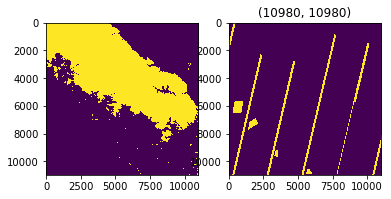

In [11]:
MaskPath = 'C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/Mask/'

cols = raster_dataset.RasterXSize
rows = raster_dataset.RasterYSize
DeepSample = np.full((rows, cols) , False, dtype= bool)
DeepSample = create_mask_from_vector(MaskPath + 'DeepSamples.shp', cols, rows, geo_transform, \
                                             proj, target_value=1, format=gdal.GDT_Byte)
DeepSample = DeepSample.GetRasterBand(1).ReadAsArray()

plt.subplot(1,2,1)
SoilIndex = gdal.Open( MaskPath+'10m.tif')
SoilIndex = SoilIndex.GetRasterBand(1).ReadAsArray().astype(np.bool_)
plt.imshow(SoilIndex)

plt.subplot(1,2,2)
plt.imshow(np.logical_or(DeepSample, FootPrintBoarders))
plt.title(DeepSample.shape)
plt.show



In [32]:
def get_X(DeepSample, FootPrint, SoilIndex, bands_data):
    assert str(bands_data.dtype) == 'float32'
    X = np.zeros(bands_data.shape, dtype= np.float32)
    SoilIndex5D = np.tile(SoilIndex[:,:,np.newaxis], (1,1,bands_data.shape[2]))

    for i in range(len(FootPrint)):
        Idx = np.logical_and( np.logical_and(FootPrint[i], ~SoilIndex), np.sum(X == 0, axis=2)>0)

        if np.sum(Idx) > 0:
            IdxDeep = np.logical_and(FootPrint[i], DeepSample)
            if np.sum(IdxDeep) == 0:
                IdxDeep = np.logical_and(FootPrint[i-1], DeepSample)

            for c in range(bands_data.shape[2]):
                X[:,:,c][Idx] = bands_data[:,:,c][Idx] - np.min(bands_data[:,:,c][IdxDeep])
                print('FootPrint: {0:d}, Bande: {1:d}, minimum :{2:0.2f}, average :{3:0.2f}'.format(i,c,np.min(bands_data[:,:,c][IdxDeep]), np.mean(bands_data[:,:,c][IdxDeep])))
                
    ErrorMap = np.logical_and(X<=0, ~SoilIndex5D)
    X[ErrorMap] = np.nan
    X[~SoilIndex5D] = np.log(X[~SoilIndex5D])
    return X, ErrorMap

X = np.empty(bands_data.shape, dtype= np.float32)
X, ErMap = get_X(DeepSample, FootPrint[0:6], SoilIndex, np.float32(bands_data))
np.savez('X_Package___'+mode+'.npz', X, ErMap)

FootPrint: 1, Bande: 0, minimum :1207.00, average :1222.97
FootPrint: 1, Bande: 1, minimum :783.00, average :824.02
FootPrint: 1, Bande: 2, minimum :408.00, average :435.30
FootPrint: 1, Bande: 3, minimum :195.00, average :220.98
FootPrint: 1, Bande: 4, minimum :155.00, average :176.35
FootPrint: 2, Bande: 0, minimum :1223.00, average :1237.25
FootPrint: 2, Bande: 1, minimum :782.00, average :823.93
FootPrint: 2, Bande: 2, minimum :415.00, average :440.12
FootPrint: 2, Bande: 3, minimum :199.00, average :222.84
FootPrint: 2, Bande: 4, minimum :159.00, average :176.56
FootPrint: 3, Bande: 0, minimum :1190.00, average :1203.49
FootPrint: 3, Bande: 1, minimum :785.00, average :821.24
FootPrint: 3, Bande: 2, minimum :407.00, average :436.28
FootPrint: 3, Bande: 3, minimum :193.00, average :222.26
FootPrint: 3, Bande: 4, minimum :157.00, average :178.27
FootPrint: 4, Bande: 0, minimum :1231.00, average :1243.88
FootPrint: 4, Bande: 1, minimum :798.00, average :838.34
FootPrint: 4, Bande: 2,

In [23]:
ClassifIndex = ~DeepIndex*~SoilIndex*(np.sum(ErMap, axis=2)==0)

np.sum(np.isnan(X[ClassifIndex]))

0

In [ ]:
plt.figure(figsize=(20, 20))

for i in range(1,6):
    plt.subplot(3, 2, i)
    plt.imshow(ErMap[:,:,i-1])
    plt.title(str(i))
    plt.axis('off')
    


In [ ]:
plt.figure(figsize=(20, 20))

for i in range(1,6):
    plt.subplot(3, 2, i)
    plt.imshow(ErMap[:,:,i-1])
    print('Band {0:d}, number of unknown NaN: {1:d}'.format(i, np.sum(np.isnan(X[:,:,i-1][~ErMap[:,:,i-1]]))))
    plt.imshow(np.logical_and(np.isnan(X[:,:,i-1]), ~ErMap[:,:,i-1]))
    plt.axis('off')

In [ ]:

Band = ['ExtraBlue', 'Blue', 'Green', 'Red', 'ExtraRed']
DepthIndexFilesPath = 'D:/Image/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/GRANULE/L1C_T58KFA_A010823_20170718T231219/IMG_DATA/DepthIndices/'

for i in range(X.shape[2]-1,-1,-1):
    for i2 in range(i-1,-1,-1):

        I = X[:,:,i][labeled_pixels == 1]
        J = X[:,:,i2][labeled_pixels == 1]
        data = get_dij_map(X[:,:,i], X[:,:,i2], I, J)
        data[np.logical_or(np.logical_or(ErMap[:,:,i], ErMap[:,:,i2]), SoilIndex)] = np.nan
        data = np.dstack((data, ErMap[:,:,i], ErMap[:,:,i2]))
        write_raster2(DepthIndexFilesPath+Band[i]+'_'+Band[i2]+'.tif', data, geo_transform, proj, DriverName="GTiff", formatMem=gdal.GDT_Float32)
        
        

In [12]:
Band = ['ExtraBlue', 'Blue', 'Green', 'Red', 'ExtraRed']
DepthIndexFilesPath = 'C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/GRANULE/L1C_T58KFA_A010823_20170718T231219/IMG_DATA/DepthIndices/'
ClassifIndex = ~DeepIndex*~SoilIndex*(np.sum(ErMap, axis=2)==0)

data = {}
for i in range(X.shape[2]-1,-1,-1):
    for i2 in range(i-1,-1,-1):

        I = X[:,:,i][labeled_pixels == 2]
        J = X[:,:,i2][labeled_pixels == 2]
        data[Band[i], Band[i2]] = get_dij_map(X[:,:,i], X[:,:,i2], I, J)
        data[Band[i], Band[i2]][np.logical_or(np.logical_or(ErMap[:,:,i], ErMap[:,:,i2]), SoilIndex)] = np.nan
        data[Band[i], Band[i2]] = np.dstack((data[Band[i], Band[i2]], ErMap[:,:,i], ErMap[:,:,i2]))
        
        

In [ ]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.imshow(DeepIndex)
plt.title('Deep')
plt.subplot(2, 2, 2)
plt.imshow(SoilIndex)
plt.title('Soil')
plt.subplot(2, 2, 3)
plt.imshow(ClassifIndex)
plt.title('Valid')
plt.subplot(2, 2, 4)
plt.imshow(np.sum(ErMap, axis=2)>0)
plt.title('Error')
    


In [24]:
Im = data['Green', 'Blue'][:,:,0]


In [28]:
Im =  color.rgb2hsv(img_as_float(bands_data[:,:,1:4]))

In [30]:
np.nanmin(Im)

0.0

In [34]:
Im[np.isnan(Im)] = -1

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


In [32]:
Im.shape

(10980, 10980, 3)

In [33]:
write_raster2('HSV.tif',Im[:,:,0], geo_transform, proj, DriverName="GTiff", formatMem=gdal.GDT_Float64)


In [ ]:
np.sum(~SoilIndex*~DeepIndex*GlobalFootPrint)

In [21]:
write_raster2('SelectedLagoon.tif', ~SoilIndex*~DeepIndex*GlobalFootPrint, geo_transform, proj, DriverName="GTiff", formatMem=gdal.GDT_Byte)
25971332*100

2597133200

In [ ]:
c=1

for i in range(X.shape[2]-1,-1,-1):
    for i2 in range(i-1,-1,-1):
        value = np.logical_and(np.isnan(data[Band[i], Band[i2]][:,:,0]),\
                                    ~np.logical_or(np.logical_or(data[Band[i], Band[i2]][:,:,1],data[Band[i], Band[i2]][:,:,2]), SoilIndex))
        print(np.sum(value))
    

        plt.subplot(5, 2, c)
        c=c+1
        plt.imshow(value)
        plt.axis('off') 

In [34]:
del X
data['colorspace','HSV_H'] = color.rgb2hsv(img_as_float(bands_data[:,:,1:4]))

In [35]:
TX = []
for i in data.keys():
    TX.append(data[i][:,:,0][ClassifIndex])

TX = np.stack(TX,axis=1)

In [ ]:
data.keys()

In [36]:
np.savez('TrainMatrixGlob_'+mode+'.npz', TX, ClassifIndex)

In [ ]:
del TX 

In [ ]:
for i in data.keys():
    values = data[i][:,:,0][ClassifIndex]
    print(np.sum(np.isnan(values)))
    print(values.shape)

In [ ]:
npzfile = np.load('TrainMatrix2_all.npz')
X = npzfile['arr_0']

In [ ]:
from sklearn import preprocessing
scaler2 = preprocessing.StandardScaler().fit(X)
X = np.array(scaler2.transform(X))

In [ ]:
TX = np.random.permutation(X)[0:5001,:]
TX.shape

In [ ]:
with open('X_train_all2_stand.csv', 'w+') as mon_fichier:
    print('ExtraRed/Red', 'ExtraRed/Green', 'ExtraRed/Blue', 'ExtraRed/ExtraBlue', 'Red/Green', 'Red/Blue', 'Red/ExtraBlue', 'Green/Blue', 'Green/ExtraBlue', 'Blue/ExtraBlue', 'colorspace/HSV_H', sep=';', file= mon_fichier)
    for i in range(TX.shape[0]):      
        print(TX[i,0],';',TX[i,1],';',TX[i,2],';',TX[i,3],';',TX[i,4],';',TX[i,5],';',TX[i,6],';',TX[i,7],';',TX[i,8],';',TX[i,9],';',TX[i,10], file= mon_fichier)
                      

In [ ]:
        print(TX[i,0],';',TX[i,1],';',TX[i,2],';',TX[i,3],';',TX[i,4],';',TX[i,5],';',TX[i,6],';',TX[i,7],';',TX[i,8],';',TX[i,9],';',TX[i,10],';')
